In [ ]:
#Import PyTorch
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch import optim


#Import TorchVision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.models as models


#import other libraries
from matplotlib import pyplot as plt
import pandas as pd
import numpy as py
from PIL import Image
import seaborn as sns
import os
import chardet
import random 
import shutil
from tqdm.auto import tqdm

In [ ]:
!unzip "/content/drive/MyDrive/Project/dataset/ubipr.zip"

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Data pre-processing

1.   First we make Train and Test folders in the main folder
2.   then we extract the labels for gender from the txt files in the folder
3.   Then we create class folders for male and female by transferring the files with the corresponding labels and put it in the train and test folders.



In [ ]:
# Set the path to your dataset folder
data_folder = '/content/ubipr/UBIPeriocular'

# Set the percentage of data to use for training
train_percent = 0.9

# Get a list of all the image files in the dataset folder
files = os.listdir(data_folder)
image_files = [f for f in files if f.endswith('.jpg')]

# Shuffle the list of image files
random.shuffle(image_files)

# Calculate the split point
split_point = int(len(image_files) * train_percent)

# Split the data into training and testing sets
train_files = image_files[:split_point]
test_files = image_files[split_point:]

# Set the paths for the training and testing folders
train_folder = os.path.join(data_folder, 'train')
test_folder = os.path.join(data_folder, 'test')

# Create the training and testing folders if they don't exist
if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(test_folder):
    os.makedirs(test_folder)

# Move the training files to the training folder along with their corresponding text file
for file in train_files:
    src_path = os.path.join(data_folder, file)
    dst_path = os.path.join(train_folder, file)
    shutil.move(src_path, dst_path)
    
    # get the corresponding text file and move it along with the image file
    text_file = file.split('.')[0] + '.txt'
    src_text_path = os.path.join(data_folder, text_file)
    dst_text_path = os.path.join(train_folder, text_file)
    shutil.move(src_text_path, dst_text_path)

# Move the testing files to the testing folder along with their corresponding text file
for file in test_files:
    src_path = os.path.join(data_folder, file)
    dst_path = os.path.join(test_folder, file)
    shutil.move(src_path, dst_path)
    
    # get the corresponding text file and move it along with the image file
    text_file = file.split('.')[0] + '.txt'
    src_text_path = os.path.join(data_folder, text_file)
    dst_text_path = os.path.join(test_folder, text_file)
    shutil.move(src_text_path, dst_text_path)



In [ ]:
folder_path = '/content/ubipr/UBIPeriocular/test'  # specify the path to the folder with images and txt files
line_num = 7  # The 7th line in the metadata contains the gender label

# create the subfolders 'male' and 'female'
os.makedirs(os.path.join(folder_path, 'male'), exist_ok=True)
os.makedirs(os.path.join(folder_path, 'female'), exist_ok=True)

gender = []

# iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        # read the file contents and extract the desired line
        with open(os.path.join(folder_path, filename), 'r') as file:
            img_filename = filename.replace('.txt', '.jpg')
            img_filepath = os.path.join(folder_path, img_filename) 
            lines = file.readlines()
            list_item = lines[line_num - 1].strip().replace(';', '')
            gender.append(list_item)

            # move the file to the appropriate subfolder
            if list_item.lower() == 'male':
                shutil.move(os.path.join(folder_path, filename), os.path.join(folder_path, 'male'))
                shutil.move(img_filepath, os.path.join(folder_path, 'male', img_filename))

            elif list_item.lower() == 'female':
                shutil.move(os.path.join(folder_path, filename), os.path.join(folder_path, 'female'))
                shutil.move(img_filepath, os.path.join(folder_path, 'female', img_filename))

print(gender)


In [ ]:
folder_path = '/content/ubipr/UBIPeriocular/train'  # specify the path to the folder with images and txt files
line_num = 7  # The 7th line in the metadata contains the gender label

# create the subfolders 'male' and 'female'
os.makedirs(os.path.join(folder_path, 'male'), exist_ok=True)
os.makedirs(os.path.join(folder_path, 'female'), exist_ok=True)

gender = []

# iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        # read the file contents and extract the desired line
        with open(os.path.join(folder_path, filename), 'r') as file:
            img_filename = filename.replace('.txt', '.jpg')
            img_filepath = os.path.join(folder_path, img_filename) 
            lines = file.readlines()
            list_item = lines[line_num - 1].strip().replace(';', '')
            gender.append(list_item)

            # move the file to the appropriate subfolder
            if list_item.lower() == 'male':
                shutil.move(os.path.join(folder_path, filename), os.path.join(folder_path, 'male'))
                shutil.move(img_filepath, os.path.join(folder_path, 'male', img_filename))

            elif list_item.lower() == 'female':
                shutil.move(os.path.join(folder_path, filename), os.path.join(folder_path, 'female'))
                shutil.move(img_filepath, os.path.join(folder_path, 'female', img_filename))

print(gender)


In [ ]:
#count the number of images in a folder
folder_path = '/content/ubipr/UBIPeriocular/test/female'

num_images = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
print(num_images)


618


# Building a model

###Building a model using raw ResNet-18 Params
1. First we import ResNet-18 into the notbook
2. Then we just pass the data as it is into ResNet-18 

In [ ]:
#import ResNet-18
model = models.resnet18(pretrained=True)

In [ ]:
# define the path to the data folder
data_path = '/content/ubipr/UBIPeriocular'
# define the transforms for training and validation data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 112)),
        transforms.RandomCrop((224, 112)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 112)),
        transforms.CenterCrop((224, 112)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


# load the datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# set the requires_grad attribute to False so that we don't backprop through the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# replace the last fully connected layer with our own classifier layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# train the model
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    for phase in ['train', 'test']:
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


  0%|          | 0/10 [00:00<?, ?it/s]

train Loss: 0.5527 Acc: 0.7754
test Loss: 0.7690 Acc: 0.7510
train Loss: 0.4884 Acc: 0.8035
test Loss: 0.6150 Acc: 0.7265
train Loss: 0.4830 Acc: 0.8088
test Loss: 0.4171 Acc: 0.8225
train Loss: 0.4699 Acc: 0.8170
test Loss: 0.5565 Acc: 0.7961
train Loss: 0.5046 Acc: 0.8036
test Loss: 0.4564 Acc: 0.8196
train Loss: 0.4634 Acc: 0.8250
test Loss: 0.4002 Acc: 0.8275
train Loss: 0.4719 Acc: 0.8147
test Loss: 0.3984 Acc: 0.8343
train Loss: 0.4980 Acc: 0.8083
test Loss: 0.6359 Acc: 0.7833
train Loss: 0.4988 Acc: 0.8076
test Loss: 0.4177 Acc: 0.8255
train Loss: 0.4433 Acc: 0.8266
test Loss: 0.4347 Acc: 0.8363


In [ ]:
#Testing a random image
image = Image.open('/content/ubipr/UBIPeriocular/test/female/C228_S1_I14.jpg')
img1 = data_transforms['test'](image)
model(img1.unsqueeze(0))


tensor([[-1.0398,  1.3251]], grad_fn=<AddmmBackward0>)

# Saving the Model
The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`. Then we can load the state dict with `torch.load`.And to load the state dict in to the network, you do `model.load_state_dict(state_dict)`.

In [ ]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

In [ ]:
#Saving the model
torch.save(model.state_dict(), 'checkpoint.pth')
state_dict = torch.load('checkpoint.pth')
 
#load the model to begin again
model.load_state_dict(state_dict)

###PeriGender Architecture
The model described as it is in the Research paper has been implemented here. The shapes and other values need to be tweaked (WIP)

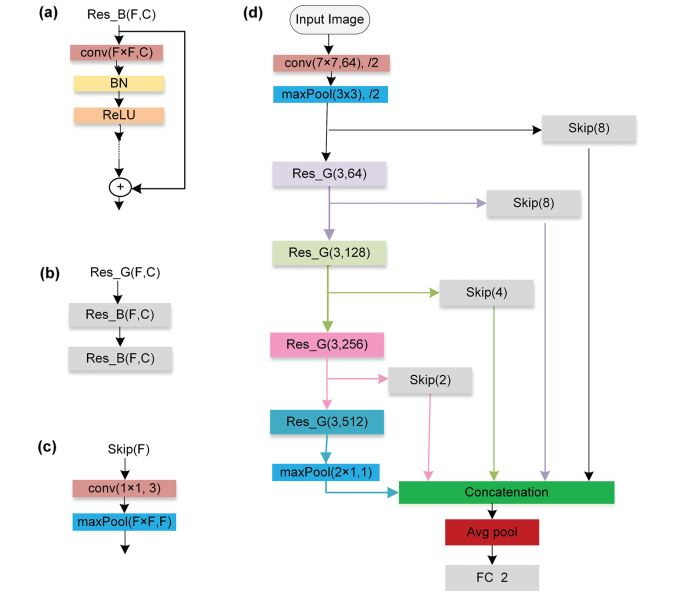

In [ ]:
#  The Residual block consists of :
#  Conv_layer_1 ---> Batch_Normalization_1 ---> ReLU_activation_function_1 
#  ---> Conv_layer_2 ---> Batc_Normalization_2 ---> ReLU_activation_function_2 

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out += identity
        out = self.relu(out)

        return out

#  The skip connection function consists of simply 2 layers :
#  Conv_layer_1 ---> MaxPool_layer_1
 
class SkipConnection(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SkipConnection, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=8, stride=8, padding=0)

    def forward(self, x):
        out = self.conv(x)
        out = self.pool(out)
        return out

#   The Perigender Layer is a combination of the aforementioned function in the following fashion : 
#    
#      1. Conv_layer_1 ---> MaxPool2d_1 
#      2. Skip_function_1
#      3. Residual_batch_1             
#      4. Skip_function_2
#      5. Residual_batch_2
#      6. Skip_function_3
#      7. Residual_function_3
#      8. Skip_function_4
#      9. Residual_function_4  
#     10. MaxPool2d_2
#     11. Concatenation_layer_1
#     12. AvgPool_layer
#

class PeriGender(nn.Module):
    def __init__(self, num_classes=2):
        super(PeriGender, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.resblock1 = nn.Sequential(ResBlock(64, 64), ResBlock(64, 64))
        self.skip1 = SkipConnection(64, 64)

        self.resblock2 = nn.Sequential(ResBlock(64, 128, stride=2), ResBlock(128, 128))
        self.skip2 = SkipConnection(128, 128)

        self.resblock3 = nn.Sequential(ResBlock(128, 256, stride=2), ResBlock(256, 256))
        self.skip3 = SkipConnection(256, 256)

        self.resblock4 = nn.Sequential(ResBlock(256, 512, stride=2), ResBlock(512, 512))
        self.skip4 = SkipConnection(512, 512)

        self.concat = nn.Sequential(nn.Conv2d(1920, 524, kernel_size=1, stride=1, padding=0), nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(524, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.resblock1(out)
        skip1 = self.skip1(out)
        out += skip1

        out = self.resblock2(out)
        skip2 = self.skip2(out)


# Training and testing loop
In this section we will 

1.   Create Train and Test folders inside each subclass

2.   Split the data 90-10

3.   Build the Training-Testing loop

4.   Build the accuracy function




In [ ]:
# Define the training function
def train(model, criterion, optimizer, train_loader, num_epochs):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Print statistics every 100 batches
            if i % 100 == 99:
                print('[Epoch %d, Batch %d] Loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
                
# Define the testing function
def test(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

# Define the transform for preprocessing the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the data
train_dataset = torchvision.datasets.ImageFolder(root='/content/ubipr/UBIPeriocular/male/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.ImageFolder(root='/content/ubipr/UBIPeriocular/male/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# Create the PeriGender CNN model, loss function, and optimizer
model = PeriGenderCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
